# Using Python to analyse data on the coronavirus

Saeed Amen - https://www.cuemacro.com - saeed@cuemacro.com

First of all I want to stress that I am not a medic. However, I am a quant, and as such I wanted to see if there are simple ways I could look at the data related to the coronavirus. In particular, I'm doing some very simple plots and analysis, but I hope you find this code useful in any case (and feel free to copy and reuse). Our data source is one compiled by John Hopkins, which they've made available on GitHub at https://github.com/CSSEGISandData/COVID-19 and is being updated daily. This dataset drives a lot of analysis that has been published on the coronavirus. 

I've tried to stick to libraries which are relatively common like Pandas and like part of the standard Anaconda installation. If you want to use these notebooks in an easy to use way, I would recommend loading them on Azure Notebooks (http://notebooks.azure.com) which has a free version), and you can rerun as new data is released. If you want to setup your Python environment similar to mine follow the instructions at https://github.com/cuemacro/teaching/blob/master/pythoncourse/installation/installing_anaconda_and_pycharm.ipynb - this will pretty much install all the libraries you'll ever need for data science.

## Loading the data

We shall be looking at several CSV from the GitHub site which have time series number of confirmed cases, deaths and recovery cases related to COVID-19, and these are updated on a regular basis. Note, we are getting the raw content from these GitHub pages.

In [1]:
# Recently changed path
confirmed_path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
deaths_path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

# Note the recovered dataset is no longer being recovered
recovered_path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

We'll also want to download some population data too from OECD, which has this path.

In [2]:
oecd_path = "https://stats.oecd.org/sdmx-json/data/DP_LIVE/.POP.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en"

Let's do some imports of libraries and creation of objects we'll need to use later.

In [3]:
import pandas as pd

%matplotlib inline

Let's check my version of pandas. Mine is 0.24.2, but this notebook will likely work with other versions too.

In [4]:
pd.__version__

'0.24.2'

Let's load up all the datasets

In [5]:
df_confirmed = pd.read_csv(confirmed_path)
df_deaths = pd.read_csv(deaths_path)
df_recovered = pd.read_csv(recovered_path) # Note: recovered dataset is not updated

Check the format up of the downloaded data for the confirmed case.

In [6]:
df_confirmed.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,16,21,22,22,22,24,24,40,40,74
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,42,51,55,59,64,70,76,89,104,123
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,48,54,60,74,87,90,139,201,230,264
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,1,2,39,39,53,75,88,113,133,164
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,0,1,2,2,3,3


We'll write a function to make the data easier to work with, transposing the dataset and making the date the index of our dataframe. We also add labels to the columns.

In [7]:
def aggregate_format_dataframe(df, label):
    # Replace some country labels to make them consistent for use later
    df['Country/Region'] = df['Country/Region'].replace('US', 'United States')
    df['Country/Region'] = df['Country/Region'].replace('Taiwan*', 'Taiwan')
    
    # Aggregate the figures by Country
    df = df.groupby(['Country/Region']).sum()
    
    df = df.transpose()
    
    # Strip first two lines (which has Lat/Long data)
    df = df[2:] 
    
    
    df.index = pd.to_datetime(df.index)
    df.index.name = 'Date'
    original_columns = df.columns
    df.columns = [x + ' ' + label for x in df.columns]
    
    return df, original_columns

Let's run that function on our datasets.

In [8]:
df_confirmed_agg, confirmed_countries = aggregate_format_dataframe(df_confirmed, 'confirmed')
df_deaths_agg, deaths_countries = aggregate_format_dataframe(df_deaths, 'deaths')

# Note: recovered dataset is not updated
df_recovered_agg, recovered_countries = aggregate_format_dataframe(df_recovered, 'recovered') 

countries = confirmed_countries

We can now see that dataset is in an easier to use format.

In [9]:
df_confirmed_agg.head(5)

,Afghanistan confirmed,Albania confirmed,Algeria confirmed,Andorra confirmed,Angola confirmed,Antigua and Barbuda confirmed,Argentina confirmed,Armenia confirmed,Australia confirmed,Austria confirmed,...,Ukraine confirmed,United Arab Emirates confirmed,United Kingdom confirmed,United States confirmed,Uruguay confirmed,Uzbekistan confirmed,Venezuela confirmed,Vietnam confirmed,Zambia confirmed,Zimbabwe confirmed
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,2.0,0.0,0.0


## Plotting the cases data

We can try plotting confirmed cases in Italy and China.

Text(0, 0.5, 'Confirmed cases')

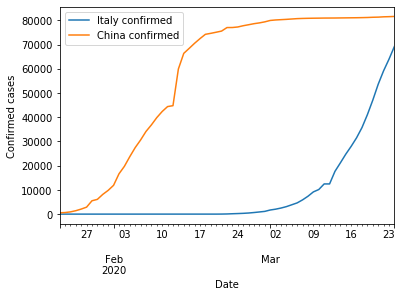

In [10]:
ax = df_confirmed_agg[['Italy confirmed', 'China confirmed']].plot()
ax.set_ylabel("Confirmed cases")

## Adjusting data by population

Obviously, it's difficult to compare these values, because of the differences in population. Let's download that data from OECD. We'll just pick up population data for 2014, the latest year available, and we strip down the dataframe, so it only has population values. Note, that this data isn't going to change often, so we can just cache it locally as a CSV.

In [11]:
import os

oecd_local_path = 'OECD.csv'

if os.path.exists(oecd_local_path):
    oecd_pop_df = pd.read_csv(oecd_local_path)
else:
    oecd_pop_df = pd.read_csv(oecd_path)
    oecd_pop_df.to_csv(oecd_local_path)

oecd_pop_df = oecd_pop_df[(oecd_pop_df['TIME'] == 2013) & (oecd_pop_df['SUBJECT'] == 'TOT') \
                              & (oecd_pop_df['MEASURE'] == 'MLN_PER')]
    
oecd_pop_df = pd.DataFrame(index=oecd_pop_df['LOCATION'].values, data=oecd_pop_df['Value'].values, columns=['Population'])
oecd_pop_df = oecd_pop_df.transpose()

If we look at the OECD data, it contains ISO codes, rather than the country names. We want to be able to convert the codes to country names, so we join it with our coronavirus dataset from earlier.

In [12]:
oecd_pop_df

,AUS,AUT,BEL,CAN,CZE,DNK,FIN,FRA,DEU,HUN,...,EST,ISR,RUS,SVN,CHN,IND,IDN,ZAF,EU28,OECD
Population,23.126,8.46857,11.17844,35.154,10.51072,5.614932,5.439,63.78614,80.611,9.893,...,1.317997,8.059,143.507,2.059114,1385.567,1252.14,249.8656,53.158,506.7358,1257.114


Let's now get the ISO codes from the various countries. We can get these from plotly express's in built gapminder datasets.

In [13]:
import plotly.express as px

iso_local_path = 'iso_code.csv'

if os.path.exists(iso_local_path):
    df_iso = pd.read_csv(iso_local_path)
else:
    df_iso = px.data.gapminder().query("year==2007")[['country', 'iso_alpha']]
    
    df_iso.index.name = 'code'

    # Relabel countries so the names match in the coronavirus dataset
    df_iso = df_iso.replace('Korea, Rep.', 'Korea, South')
    df_iso = df_iso.replace('Czech Republic', 'Czechia')
    df_iso = df_iso.replace('Slovak Republic', 'Slovakia')
    df_iso = df_iso[df_iso['country'] != 'Korea, Dem. Rep.']

    # Some countries are missing that we need to add
    extra_countries = [(170, 'Colombia', 'COL'),
    (376, 'Israel', 'ISR'),
    (643, 'Russia', 'RUS'),
    (233, 'Estonia', 'EST'),
    (442, 'Luxembourg', 'LUX')]

    df_iso_extra = pd.DataFrame(data=extra_countries, columns=['code', 'country', 'iso_alpha'])
    df_iso_extra = df_iso_extra.set_index('code')
    
    df_iso = df_iso.append(df_iso_extra)
    
    df_iso.to_csv(iso_local_path)

Let's have a look at the ISO code dataset.

In [14]:
df_iso.head(5)

,code,country,iso_alpha
0,11,Afghanistan,AFG
1,23,Albania,ALB
2,35,Algeria,DZA
3,47,Angola,AGO
4,59,Argentina,ARG


We can replace the OECD ISO codes in the columns with the country names (with exceptions), so both datasets have matching names.

In [15]:
lst = []

for col in oecd_pop_df.columns:
    try:
        col = df_iso['country'][df_iso['iso_alpha'] == col].values[0]
    except:
        pass
    
    lst.append(col)

oecd_pop_df.columns = lst

We see we have relabelled the countries and also remove EU28 and OECD, given the coronavirus dataset doesn't have this data for aggregated grouping of countries.

In [16]:
excluded_countries = ['EU28', 'OECD']
oecd_countries = [x for x in oecd_pop_df.columns if x not in excluded_countries]
oecd_pop_df = oecd_pop_df[oecd_countries]

oecd_pop_df.columns

Index(['Australia', 'Austria', 'Belgium', 'Canada', 'Czechia', 'Denmark',
       'Finland', 'France', 'Germany', 'Hungary', 'Iceland', 'Ireland',
       'Italy', 'Japan', 'Korea, South', 'Luxembourg', 'Mexico', 'Netherlands',
       'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovakia', 'Spain',
       'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States',
       'Brazil', 'Chile', 'Colombia', 'Estonia', 'Israel', 'Russia',
       'Slovenia', 'China', 'India', 'Indonesia', 'South Africa'],
      dtype='object')

Our dataset now only has the population values. One slight complication is that currency codes do not match our earlier datasets. The population of Italy is 60 million, whereas for China it is 1385 million. Admittedly this might be an simplistic comparison, given that most of the cases in China were in a specific area Hubei, which has a population of 58.5 million (from https://en.wikipedia.org/wiki/Hubei). Also for Italy most of the cases at the start of the episode have been in Northern Italy.

In [17]:
oecd_pop_df[['Italy', 'China']]

,Italy,China
Population,60.22473,1385.567


Let's create a copy of the confirmed data and we'll then normalize the values by population for OECD countries where we have population data.

In [18]:
def normalize_data_by_pop(df, pop_df, label, countries_to_normalize):

    df = df.copy()

    for x in countries_to_normalize:
        df[x + ' ' + label] = df[x + ' ' + label].values / pop_df[x].values[0]
        
        
    return df
        
df_confirmed_oecd_normalized = normalize_data_by_pop(df_confirmed_agg, oecd_pop_df, 'confirmed', oecd_countries)
df_death_oecd_normalized = normalize_data_by_pop(df_deaths_agg, oecd_pop_df, 'deaths', oecd_countries)

If we plot the normalized figure, the number of confirmed cases looks worse in Italy compared to China.

Text(0, 0.5, 'Confirmed cases/Total population (millions)')

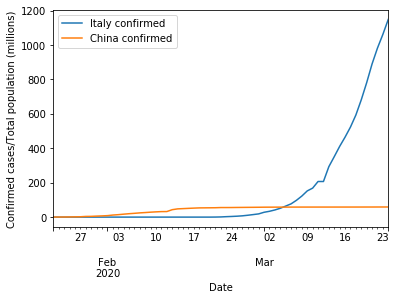

In [19]:
ax = df_confirmed_oecd_normalized[['Italy confirmed', 'China confirmed']].plot()
ax.set_ylabel("Confirmed cases/Total population (millions)")

Let's compare the total number of confirmed cases in Italy and the United Kingdom, which have relatively similar population levels. In this case we have shifted the UK values by 2 weeks. Thus far it seems as though the UK's confirmed cases is following the same pattern as Italy.

Text(0, 0.5, 'Confirmed cases')

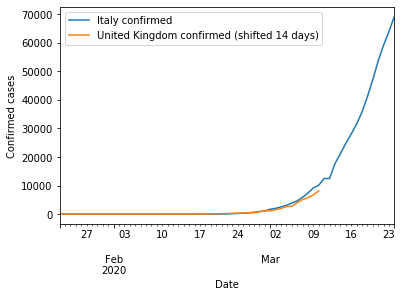

In [20]:
df_confirmed_agg_lag = df_confirmed_agg.copy()

df_confirmed_agg_lag['United Kingdom confirmed (shifted 14 days)'] = df_confirmed_agg_lag['United Kingdom confirmed'].shift(-14)
ax = df_confirmed_agg_lag[['Italy confirmed', 'United Kingdom confirmed (shifted 14 days)']].plot()
ax.set_ylabel("Confirmed cases")

Let's combine the confirmed cases with the deaths data, so we can compare the data.

In [21]:
df_confirmed_deaths_df = df_confirmed_agg.join(df_deaths_agg)

Let's plot it for Italy.

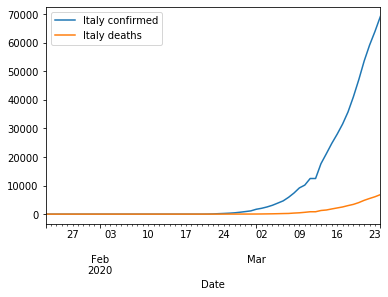

In [22]:
ax = df_confirmed_deaths_df[['Italy confirmed', 'Italy deaths']].plot()

## Adjusting confirmed cases by deaths

Next, we want to calculate the number of confirmed/death percentage. Note, for a large part of the sample this will be undefined for Italy (when there were no confirmed cases or deaths, which we shall label as zero).

In [23]:
countries_confirmed = [x + ' confirmed' for x in countries]
countries_deaths = [x + ' deaths' for x in countries]
countries_ratio = [x + ' deaths/confirmed' for x in countries]

perc = 100.0 * (df_deaths_agg[countries_deaths].values / df_confirmed_agg[countries_confirmed].values)

df_death_confirmed_perc = pd.DataFrame(index=df_deaths_agg.index, data=perc, columns=countries_ratio)
df_death_confirmed_perc = df_death_confirmed_perc.fillna(0) 

C:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in true_divide



We can plot the percentages for China and Italy. For China it's been between 2-4%, although it appears higher in some sections of the time series in Italy. One reason can also be the number of tests conducted versus the overall population. As of March 3, 2020, [WHO reported](https://www.who.int/dg/speeches/detail/who-director-general-s-opening-remarks-at-the-media-briefing-on-covid-19---3-march-2020) a figure of 3.4% globally.

Text(0.5, 0, 'Deaths/confirmed percentage')

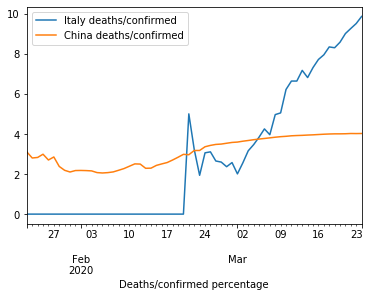

In [24]:
ax = df_death_confirmed_perc[['Italy deaths/confirmed', 'China deaths/confirmed']].plot()
ax.set_xlabel('Deaths/confirmed percentage')

Let's take the last available date for values, and then convert our DataFrame into tidy format (see https://cfss.uchicago.edu/notes/tidy-data/ for a description), which can be utilised more easily by certain Python libraries.

In [25]:
df_death_confirmed_perc_tidy = df_death_confirmed_perc.tail(1)
df_death_confirmed_perc_tidy.columns = [x.replace(' deaths/confirmed', '') for x in df_death_confirmed_perc_tidy.columns]
df_death_confirmed_perc_tidy = df_death_confirmed_perc_tidy.melt()
df_death_confirmed_perc_tidy.columns = ['country', 'deaths/confirmed perc']

import numpy as np
df_death_confirmed_perc_tidy = df_death_confirmed_perc_tidy.replace(0, np.nan)

Let's display the tidy DataFrame.

In [26]:
df_death_confirmed_perc_tidy.head(5)

,country,deaths/confirmed perc
0,Afghanistan,1.351351
1,Albania,4.065041
2,Algeria,7.196970
3,Andorra,0.609756
4,Angola,NaN


## Plotting cases on a world map

We can now plot it using plotly express to create a world map using the death/confirmed ratio. But before we do that, we need to get the iso_codes for each country, which we got earlier from plotly express's in built gapminder datasets.

In [27]:
import plotly.express as px

df_death_confirmed_perc_tidy = df_death_confirmed_perc_tidy.merge(df_iso, on='country')

We now have a DataFrame with the additional iso_alpha column.

In [28]:
df_death_confirmed_perc_tidy.head(5)

,country,deaths/confirmed perc,code,iso_alpha
0,Afghanistan,1.351351,11,AFG
1,Albania,4.065041,23,ALB
2,Algeria,7.196970,35,DZA
3,Angola,NaN,47,AGO
4,Argentina,1.550388,59,ARG


We can plot a world map of the death/confirmed percentages. Some might seem very high, because of a very small number of deaths and confirmed cases. Also have a look at https://covidlive.co.uk/ which has a live updated map for UK cases.

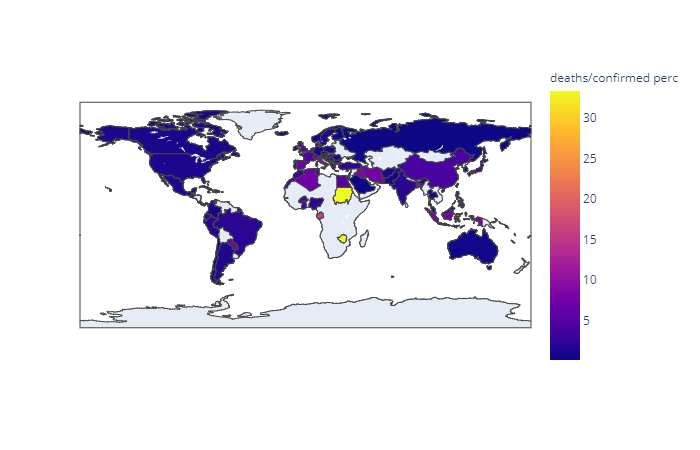

In [29]:
import plotly.io as pio
# pio.renderers.default = "notebook" # make plots interactive (but will disappear when reopening notebook!)
pio.renderers.default = "png" # static images

fig = px.choropleth(df_death_confirmed_perc_tidy, locations="iso_alpha",
                    color="deaths/confirmed perc", 
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()

## Adjusting timelines by lags

Earlier, we showed some plots of UK and Italy, where the UK was lagged by 14 days, to take into account the relative starts of the outbreaks. Can we do this in a systematic way, rather than arbitrarily trying to pick a lag. One way to do this is to reindex our data, so that the timeline is automically shifted. The [FT](https://www.ft.com/coronavirus-latest) has produced some excellent visualisations based on shifts related to:

* confirmed cases are lagged by the number of days since 100th confirmed case related to the coronavirus
* deaths are lagged by the number of days since 10th death related to the coronavirus

We'll copy the same approach used by the FT, and other analysis based on this dataset. (Thanks Ewan Kirk for contributing to this!)

In [30]:
def timeline_lag(df, rate): 

    df = df.copy()
    
    # Lag each column so it starts with the rate
    for col in df.columns.values:
        try:
            shift = df.index.get_loc(df[df[col] > rate].index[0])
        except IndexError:
            shift = df_confirmed.shape[0]

        df[col] = df[col].shift(-1*shift)
    
    df['NumDays'] = range(0, df.shape[0])
    df.set_index('NumDays', inplace=True)
        
    return df

df_confirmed_agg_lag_ft = timeline_lag(df_confirmed_agg, 100)
df_deaths_agg_lag_ft = timeline_lag(df_deaths_agg, 10)

df_confirmed_oecd_normalized_lag_ft = timeline_lag(df_confirmed_agg, 100)
df_deaths_oecd_normalized_lag_ft = timeline_lag(df_deaths_agg, 10)

Let's now plot the lagged time series by days since 100th confirmed case for a few countries.

Text(0.5, 0, 'Days since 100th confirmed case')

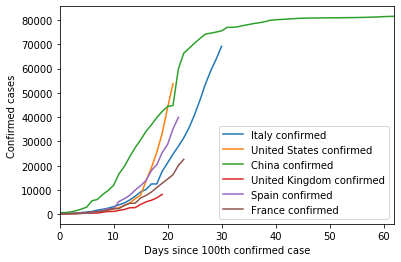

In [31]:
countries_to_plot = ['Italy', 'United States', 'China', 'United Kingdom', 'Spain', 'France']

ax = df_confirmed_agg_lag_ft[[x + ' confirmed' for x in countries_to_plot]].plot()
ax.set_ylabel("Confirmed cases")
ax.set_xlabel("Days since 100th confirmed case")

# Change log

* 25 Mar 2020 
    * Updated to use new dataset location from https://github.com/CSSEGISandData/COVID-19/
    * Improved ISO country code joining
    * Added section on adjusting timelines
* 12 Mar 2020
    * First upload of coronavirus notebook